# Introduction

**Members:** 

Alesandro Michael Ferdinand (101228984)

Bryan Austyn Ichsan (101229576)

Ng Jing Ping (101211418)


---



**Unit:** COS30082 - Applied Machine Learning



---





There are a lot of species of plants in the world and botanist need to be able to identify them for their research need. Identifying numerous species of plants itself has been a hard thing by itself, identifying the species of plants on tropical area which does not have a lot of references to be used adds more challenges for botanists and reseachers. In order to solve the lack of references that can be used by the researchers to identify the species of plants in the real environment, Computer Vision comes to help by learning about the herbarium data of the plants thus it is targeted that the AI itself can also identify the species of the plants in the real field environment. Having an AI that can help the researchers and botanist to get the predicted species of the plants will really help the researchers and the botanist to conduct their research easier. This project is targeted to develop an AI that can be used to solve the stated issue with several different approaches of Machine Learning (and Deep Learning as the subset of Machine Learning).

# Data Preparation

First of all, we will need to prepare the data that we will use for the project whereby the data is taken from the PlantCLEF 2020 Challenge which contains 100 species of plants with 2 different type of images, herbarium and field. We will need to load the data first.

In [ ]:
# Import required libraries
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Connect to Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the data to Colab Session
!unzip drive/MyDrive/AML_project/train.zip > /dev/null
!unzip drive/MyDrive/AML_project/test.zip > /dev/null

!cp "/content/drive/MyDrive/AML_project/list/train.txt" "train.txt"
!cp "/content/drive/MyDrive/AML_project/list/groundtruth.txt" "groundtruth.txt"

# You can click on the loaded data on the files explorer tab of Colab to have a look on the data

In [ ]:
# Since AI can process numbers only, we will need to load the image data into numbers
def convert_image_to_numpy(image_paths_arr):
  dataset_nparr = list()

  for path in image_paths_arr:
    image_data = image.imread(path)
    image_data = tf.cast(image_data, tf.float32)/255
    image_data = tf.image.resize(image_data, (128, 128), method = "bilinear")
    dataset_nparr.append(image_data)

  return np.array(dataset_nparr)

In [ ]:
# The labels given on the dataset is not in ordered manner, thus classification model
# might assume that there is more than 100 species because of the codes of the species.
# We will need to encode those codes into nomimal data for the model to use
def encode_labels(labels_arr):
  label_encoder = LabelEncoder()
  return label_encoder.fit_transform(labels_arr)

In [ ]:
# We will need to take the picture from the dedicated folders and match it with the labels on the
# txt file. In order to do so, we will need to read the txt file then split the line into the path of the image
# and the labels. We will then load the image based on the path to numbers and encode the labels.
# This code will be used for loading the mixed stream data
def load_data(text_file):
  with open(text_file) as txt_file:
    # read the file, with format "path label"
    # e.g. train/photo/106023/1769.jpg 106023
    lines_arr = [line.strip() for line in txt_file.readlines()]

    # split the lines to image path and label
    image_paths = [line.split(' ')[0] for line in lines_arr]
    labels = [line.split(' ')[1] for line in lines_arr]

    x_data = convert_image_to_numpy(image_paths)
    y_data = encode_labels(labels)

    return x_data, y_data, labels

In [ ]:
# Loading the data into herbarium and fields will be a bit different compared to the mixed stream one
# as we need to classify either the image belongs to field or herbarium. We will then load the image and encode the labels
# separetely thus we can get the separated data of herbarium and fields
def load_separated_data(text_file):
  with open(text_file) as txt_file:
    lines_arr = [line.strip() for line in txt_file.readlines()]

    natural_image_paths = []
    natural_labels = []

    herbarium_image_paths = []
    herbarium_labels = []

    for line in lines_arr:
      full_path = line.split(' ')[0]
      photo_type = full_path.split('/')[1]
      if(photo_type == "photo"):
        natural_image_paths.append(full_path)
        natural_labels.append(line.split(' ')[1])
      else:
        herbarium_image_paths.append(full_path)
        herbarium_labels.append(line.split(' ')[1])

    x_natural = convert_image_to_numpy(natural_image_paths)
    y_natural = encode_labels(natural_labels)

    x_herbarium = convert_image_to_numpy(herbarium_image_paths)
    y_herbarium = encode_labels(herbarium_labels)

    return x_natural, y_natural, x_herbarium, y_herbarium

In [ ]:
# Load the training set as mixed stream data
x_train, y_train, train_labels = load_data("train.txt")

In [ ]:
# Load the training set as separated data (herbarium and field)
x_natural, y_natural, x_herbarium, y_herbarium = load_separated_data("train.txt")

In [ ]:
# Load the test set
x_test, y_test, test_labels = load_data("groundtruth.txt")

In [ ]:
# Check the shapes to ensure that the data has been loaded correctly
print("Shapes Checking")
print("X-natural: " + str(x_natural.shape))
print("y-natural: " + str(y_natural.shape))
print("X-herbarium: " + str(x_herbarium.shape))
print("y-herbarium: " + str(y_herbarium.shape))

Shapes Checking
X-natural: (1044, 128, 128, 3)
y-natural: (1044,)
X-herbarium: (3700, 128, 128, 3)
y-herbarium: (3700,)


In [ ]:
# The mixed stream data should have bigger size as it is the mixed of herbarium and fields
print("Shapes Checking")
print("X-train: " + str(x_train.shape))
print("y-train: " + str(y_train.shape))
print("X-test: " + str(x_test.shape))
print("y-test: " + str(y_test.shape))

Shapes Checking
X-train: (4744, 128, 128, 3)
y-train: (4744,)
X-test: (207, 128, 128, 3)
y-test: (207,)


# Modelling

Before we started to explore the models one-by-one, we will need to define the common metrics that will be used by the models first thus the model can be trained under the similar condition for fair comparison.


Three Model for this project: 
1.   Base Model with Mixed Stream Data 
2.   Base model with oversampling
3.   Transfer Learning with Mixed Stream Data



In [ ]:
# Load the required libraries
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [ ]:
# First, we will need to load the evaluation metrics that we will use for the project
# which are the top-1 accuracy (also known as accuracy) and top-5 accuracy
from keras.metrics import sparse_top_k_categorical_accuracy

def top_5_accuracy(y_true, y_pred):
  return sparse_top_k_categorical_accuracy (y_true, y_pred, k=5)

In [ ]:
# Make the function that will help us to show the performance of the model in term of its
# loss and accuracy trends hence we can determine whether the model is overfitting, underfitting, or
# well-trained
def plot_performance(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize=[8,6])
  plt.plot(loss,'r',linewidth=3.0)
  plt.plot(val_loss,'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  plt.figure(figsize=[8,6])
  plt.plot(accuracy,'r',linewidth=3.0)
  plt.plot(val_accuracy,'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Base Model with Mixed Stream Data

The first model that we will train is a CNN model with mixed stream data, meaning that the model will be trained by using a mixed dataset of field and herbarium image.

In [ ]:
# Fetch the information about the number of classess on the training set
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
# The input shape will the shape of the image itself
nRows,nCols,nDims = x_train.shape[1:]
input_shape = (nRows, nCols, nDims)

In [ ]:
# To add more varieties to the dataset, we can do data augmentation simply by
# flipping or rotating the images
datagen = ImageDataGenerator(horizontal_flip=True,
                            rotation_range=45,
                            zoom_range=0.8,
                            vertical_flip=True)

datagen.fit(x_train)

In [ ]:
# Create the CNN model
def createModel():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding = "same", kernel_regularizer=regularizers.L1(0.01), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [ ]:
# Print out the model information
cnn_model = createModel()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 16)        0

In [ ]:
# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', top_5_accuracy])
batch_size = 32
steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) )
initial_epochs = 32
history = cnn_model.fit(datagen.flow(x_train, y_train), batch_size=batch_size, steps_per_epoch=steps_per_epoch,
              epochs=initial_epochs, verbose=1, validation_data=(x_test, y_test))

Epoch 1/32
149/149 [==============================] - 27s 120ms/step - loss: 4.9681 - accuracy: 0.0141 - top_5_accuracy: 0.0578 - val_loss: 4.6801 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0676
Epoch 2/32
149/149 [==============================] - 18s 118ms/step - loss: 4.5864 - accuracy: 0.0175 - top_5_accuracy: 0.0753 - val_loss: 4.6080 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0580
Epoch 3/32
149/149 [==============================] - 18s 119ms/step - loss: 4.4983 - accuracy: 0.0255 - top_5_accuracy: 0.0999 - val_loss: 4.7991 - val_accuracy: 0.0193 - val_top_5_accuracy: 0.0773
Epoch 4/32
149/149 [==============================] - 18s 118ms/step - loss: 4.4239 - accuracy: 0.0287 - top_5_accuracy: 0.1294 - val_loss: 4.9377 - val_accuracy: 0.0242 - val_top_5_accuracy: 0.0966
Epoch 5/32
149/149 [==============================] - 19s 126ms/step - loss: 4.3574 - accuracy: 0.0401 - top_5_accuracy: 0.1570 - val_loss: 4.8654 - val_accuracy: 0.0290 - val_top_5_accuracy: 0.0773
Epoch

In [ ]:
# Evaluate the performance of the base model with mixed stream data
cnn_model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 15ms/step - loss: 5.1256 - accuracy: 0.0483 - top_5_accuracy: 0.2222


[5.1256103515625, 0.04830917716026306, 0.2222222238779068]

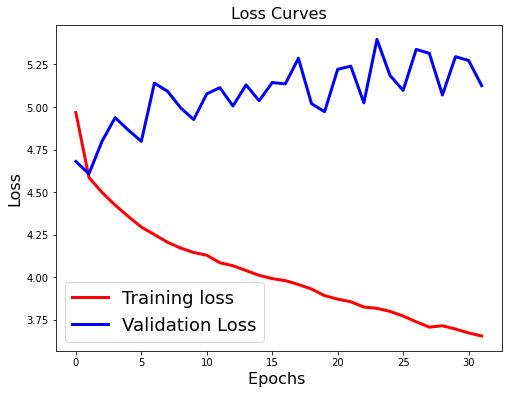

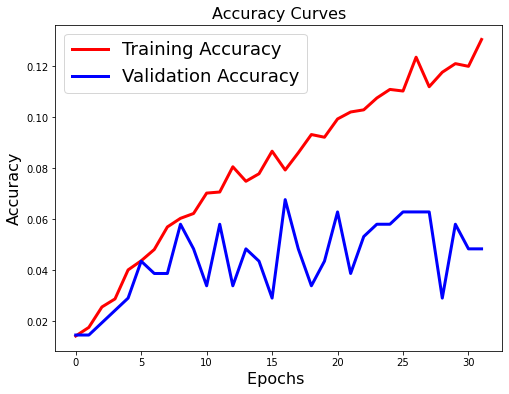

In [ ]:
# Plot the performance of the model
plot_performance(history)

## Base model with oversampling

The second approach that we will try to increase the performance of the CNN model is by oversampling the data. Current data has some classes that have only few number of data while the other classess have more data in significant amount. Training a model with this kind of data might cause the model to be biased because of the skewed distribution of data. Oversampling is an approach that can be considered to solve this kind of issue simply by appending random data to the classes that have less amount of data. RandomOverSampler will help us to do so by picking the minority classess then generating random data to add more information for the classess with less amount of data. Oversampling was more preferred compared to undersampling simply because of the small amount of data that we have. However, oversampling comes with a risk for the model to perform even worse because of the random noisy data so the approach itself will need to be handled carefully.

In [ ]:
# Import the required library
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversample the train set
ReX_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
print(ReX_train.shape)

ros = RandomOverSampler(sampling_strategy="not majority") # String
x_train_oversampled, y_train_oversampled = ros.fit_resample(ReX_train, y_train)

(4744, 49152)


In [ ]:
# Reshape the oversampled data to fit the input shape of the CNN model
# We can see that the amount of data for the training set has changed from 4744 -> 5000

x_train_oversampled = x_train_oversampled.reshape(x_train_oversampled.shape[0], 128, 128, 3)
x_train_oversampled.shape

(5000, 128, 128, 3)

In [ ]:
# Call Create Model
cnn_model = createModel()
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy",top_5_accuracy])

In [ ]:
# Train the same model but now with the oversampled data
history_oversampled = cnn_model.fit(datagen.flow(x_train_oversampled, y_train_oversampled), batch_size=batch_size, steps_per_epoch = steps_per_epoch,
              epochs=initial_epochs, verbose=1, validation_data= (x_test, y_test))

Epoch 1/32
149/149 [==============================] - 18s 120ms/step - loss: 5.0777 - accuracy: 0.0086 - top_5_accuracy: 0.0441 - val_loss: 4.8456 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0386
Epoch 2/32
149/149 [==============================] - 18s 119ms/step - loss: 4.7745 - accuracy: 0.0084 - top_5_accuracy: 0.0426 - val_loss: 4.7173 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0435
Epoch 3/32
149/149 [==============================] - 18s 118ms/step - loss: 4.6855 - accuracy: 0.0070 - top_5_accuracy: 0.0405 - val_loss: 4.6601 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0531
Epoch 4/32
149/149 [==============================] - 18s 120ms/step - loss: 4.6450 - accuracy: 0.0093 - top_5_accuracy: 0.0428 - val_loss: 4.6316 - val_accuracy: 0.0145 - val_top_5_accuracy: 0.0628
Epoch 5/32
149/149 [==============================] - 18s 120ms/step - loss: 4.6251 - accuracy: 0.0076 - top_5_accuracy: 0.0407 - val_loss: 4.6187 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0531
Epoch

In [ ]:
# Evaluate the performance of the model.
cnn_model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 18ms/step - loss: 4.6073 - accuracy: 0.0097 - top_5_accuracy: 0.0483


[4.607281684875488, 0.009661835618317127, 0.04830917716026306]

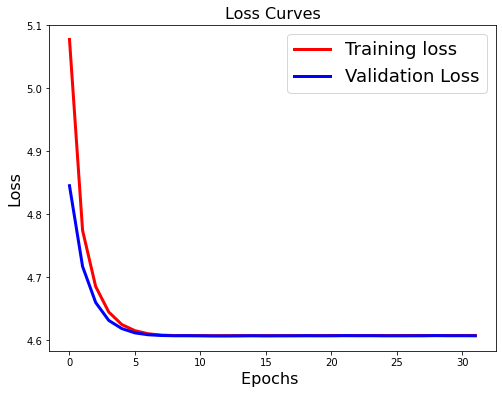

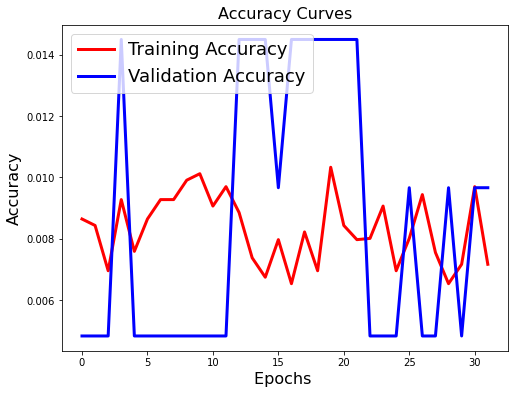

In [ ]:
# Plot the performance of model with oversampled data
plot_performance(history_oversampled)

## Transfer Learning with Mixed Stream Data

*: MobileNetV2*

With the limited amount of data that we have, it might be hard to get a really good model if we train everything from scratch as a deep learning model need a big amount of data to understand the data well enough. In order to solve this kind of issue, we can try to utilize pre-trained model to help us in getting better model performance for project that we are working on.

In [ ]:
# Import the required libraries
from keras.applications import MobileNetV2 # We will use MobileNetV2 as our pre-trained model
from keras.applications.mobilenet_v2 import preprocess_input
from matplotlib import image
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, RandomFlip, RandomRotation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
# Load the pre-trained model but remove the classification layer or the output layer from the model
# as we will put some extra layer on top of it manually
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# We will freeze all the layers of the pre-trained model for now to prevent the embedded weight from been updated
base_model.trainable = False

In [ ]:
# We will do simple data augmentation by flipping and rotating the image.
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)
])

In [ ]:
# Look for the amount of classess for training
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
# Build the model by including the pre-trained model among the other layers
inputs = tf.keras.Input(shape=(128, 128, 3))
augmented_data = data_augmentation(inputs)
pretrained_data = base_model(augmented_data, training=False) #Fit the augmented data to the pre-trained model
pooled_data = tf.keras.layers.GlobalAveragePooling2D()(pretrained_data) #Use the output of pre-trained model to be further processed
dropped_data = Dropout(0.4)(pooled_data)
outputs = Dense(nClasses, activation = 'softmax')(dropped_data) #Output/Classification layer
model = tf.keras.Model(inputs, outputs)

In [ ]:
# We will utilize ADAM as the optimizer but take note that the learning rate is smaller compared to the other two models
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

In [ ]:
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy",top_5_accuracy])

In [ ]:
# Let's add more data by augmenting the data with different approach
datagen = ImageDataGenerator(horizontal_flip=True,
                            rotation_range=45,
                            zoom_range=0.8,
                            vertical_flip=True)

datagen.fit(x_train)

# We will try to train the model with 20 epoch first before we fine-tune the model later on
batch_size = 32
steps_per_epoch = int( np.ceil(x_train.shape[0] / batch_size) )
initial_epochs = 20

In [ ]:
# Train the model
history_transfer = model.fit(
    datagen.flow(x_train, y_train),
    batch_size=batch_size,
    steps_per_epoch = steps_per_epoch,
    epochs=initial_epochs,
    verbose=1,
    validation_data= (x_test, y_test)
)

Epoch 1/20
149/149 [==============================] - 23s 133ms/step - loss: 5.8607 - accuracy: 0.0082 - top_5_accuracy: 0.0472 - val_loss: 5.3263 - val_accuracy: 0.0000e+00 - val_top_5_accuracy: 0.0531
Epoch 2/20
149/149 [==============================] - 19s 124ms/step - loss: 5.7540 - accuracy: 0.0091 - top_5_accuracy: 0.0485 - val_loss: 5.2770 - val_accuracy: 0.0000e+00 - val_top_5_accuracy: 0.0483
Epoch 3/20
149/149 [==============================] - 19s 125ms/step - loss: 5.6665 - accuracy: 0.0091 - top_5_accuracy: 0.0584 - val_loss: 5.2414 - val_accuracy: 0.0000e+00 - val_top_5_accuracy: 0.0531
Epoch 4/20
149/149 [==============================] - 19s 125ms/step - loss: 5.5943 - accuracy: 0.0103 - top_5_accuracy: 0.0508 - val_loss: 5.2135 - val_accuracy: 0.0048 - val_top_5_accuracy: 0.0531
Epoch 5/20
149/149 [==============================] - 19s 126ms/step - loss: 5.5635 - accuracy: 0.0126 - top_5_accuracy: 0.0575 - val_loss: 5.1906 - val_accuracy: 0.0097 - val_top_5_accuracy: 

It seems like the performance of the pre-trained model is still not satisfying at this point, we might need to fine-tune the pre-trained model to adjust its weight according to our data.

In [ ]:
# Unfreeze the pretrained model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
# Compile the model that we will fine-tune
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy",top_5_accuracy])

In [ ]:
# Continue the training from the latest epoch (20) until it reachs 32 as the epochs of the other model
fine_tune_epochs = 12
total_epochs =  initial_epochs + fine_tune_epochs

# Fine-tune the model
history_transfer_fine = model.fit(
    datagen.flow(x_train, y_train),
    batch_size=batch_size,
    steps_per_epoch = steps_per_epoch,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1],
    verbose=1,
    validation_data= (x_test, y_test)
)

Epoch 20/32
149/149 [==============================] - 25s 139ms/step - loss: 4.6275 - accuracy: 0.0108 - top_5_accuracy: 0.0626 - val_loss: 4.5875 - val_accuracy: 0.0097 - val_top_5_accuracy: 0.0435
Epoch 21/32
149/149 [==============================] - 20s 134ms/step - loss: 4.5886 - accuracy: 0.0152 - top_5_accuracy: 0.0719 - val_loss: 4.5716 - val_accuracy: 0.0000e+00 - val_top_5_accuracy: 0.0918
Epoch 22/32
149/149 [==============================] - 20s 133ms/step - loss: 4.5511 - accuracy: 0.0278 - top_5_accuracy: 0.0995 - val_loss: 4.5716 - val_accuracy: 0.0338 - val_top_5_accuracy: 0.1014
Epoch 23/32
149/149 [==============================] - 21s 141ms/step - loss: 4.4751 - accuracy: 0.0352 - top_5_accuracy: 0.1216 - val_loss: 4.5243 - val_accuracy: 0.0338 - val_top_5_accuracy: 0.1304
Epoch 24/32
149/149 [==============================] - 20s 133ms/step - loss: 4.3848 - accuracy: 0.0453 - top_5_accuracy: 0.1473 - val_loss: 4.4440 - val_accuracy: 0.0483 - val_top_5_accuracy: 0.1

In [ ]:
# Evaluate the performance of the pre-trained model approach
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 20ms/step - loss: 4.2618 - accuracy: 0.1353 - top_5_accuracy: 0.2657


[4.261824607849121, 0.13526569306850433, 0.26570048928260803]

In [ ]:
# Append the new history information so we can show the fine-tuning effect on graph later on
loss = history_transfer.history['loss'].copy()
val_loss = history_transfer.history['val_loss'].copy()

loss += history_transfer_fine.history['loss']
val_loss += history_transfer_fine.history['val_loss']

accuracy = history_transfer.history['accuracy'].copy()
val_accuracy = history_transfer.history['val_accuracy'].copy()

accuracy += history_transfer_fine.history['accuracy']
val_accuracy += history_transfer_fine.history['val_accuracy']

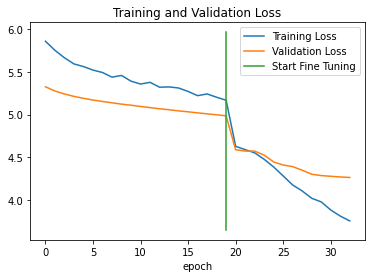

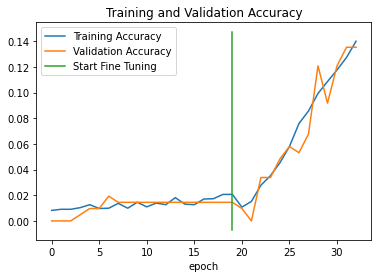

In [ ]:
# Plot the performance of the pre-trained model before and after fine-tuning
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# It seems like the pre-trained model is the best model in term of performance compared to the other 2 models so far
# By that, we will take this model to be used on our GUI and Jetson Nano so we will need to save this model to our drive.
model.save("/content/drive/MyDrive/AML_project/saved_models")

# Result

After modeling, the results of this project were based on:
1.   Base Model with Mixed Stream Data 
2.   Base model with oversampling
3.   Transfer Learning with Mixed Stream Data

In [ ]:
df = pd.DataFrame(columns=['Model', 'Epochs', 'Training Accuracy', 'Validation Accuracy'])

In [ ]:
# Base Model with Mix Stream Data
df = df.append({
    'Model': 'Base Model with Mix Stream Data',
    'Epochs': 32,
    'Training Accuracy': 'Top-1: ' + str(round(history.history['accuracy'][-1], 3)) + ', Top-5: ' + str(round(history.history['top_5_accuracy'][-1], 3)),
    'Validation Accuracy': 'Top-1: ' + str(round(history.history['val_accuracy'][-1], 3)) + ', Top-5: ' + str(round(history.history['val_top_5_accuracy'][-1], 3))
}, ignore_index=True)

# Base Model with Oversampled Mix Stream Data
df = df.append({
    'Model': 'Base Model with Oversampled Mix Stream Data',
    'Epochs': 32,
    'Training Accuracy': 'Top-1: ' + str(round(history_oversampled.history['accuracy'][-1], 3)) + ', Top-5: ' + str(round(history_oversampled.history['top_5_accuracy'][-1], 3)),
    'Validation Accuracy': 'Top-1: ' + str(round(history_oversampled.history['val_accuracy'][-1], 3)) + ', Top-5: ' + str(round(history_oversampled.history['val_top_5_accuracy'][-1], 3))
}, ignore_index=True)

# Transfer Learning with Mixed Stream Data
df = df.append({
    'Model': 'Transfer Learning with Mixed Stream Data',
    'Epochs': 32,
    'Training Accuracy': 'Top-1: ' + str(round(history_transfer_fine.history['accuracy'][-1], 3)) + ', Top-5: ' + str(round(history_transfer_fine.history['top_5_accuracy'][-1], 3)),
    'Validation Accuracy': 'Top-1: ' + str(round(history_transfer_fine.history['val_accuracy'][-1], 3)) + ', Top-5: ' + str(round(history_transfer_fine.history['val_top_5_accuracy'][-1], 3))
}, ignore_index=True)

In [ ]:
df

,Model,Epochs,Training Accuracy,Validation Accuracy
0,Base Model with Mix Stream Data,32,"Top-1: 0.13, Top-5: 0.36","Top-1: 0.048, Top-5: 0.222"
1,Base Model with Oversampled Mix Stream Data,32,"Top-1: 0.007, Top-5: 0.039","Top-1: 0.01, Top-5: 0.048"
2,Transfer Learning with Mixed Stream Data,32,"Top-1: 0.14, Top-5: 0.345","Top-1: 0.135, Top-5: 0.266"
